## Non-linear refiment
Non-linear refiment of the homography matrix using **Levenberg-Marquardt**

In [9]:
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

import numpy as np

In [12]:
def toHomo(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def fromHomo(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1,:]/x[-1,:]

def normalize(x):
    dim = x.shape[0]
    # Shift centroid to origin
    m = x.mean(axis=1)
    if dim==3:
        tx = np.array([[1, 0, -m[0]], [0, 1, -m[1]], [0, 0, 1]])
    elif dim==4:
        tx = np.array([[1, 0, 0, -m[0]], [0, 1, 0, -m[1]], [0, 0, 1, -m[2]], [0, 0, 0, 1]])
    
    # Apply translation
    x = tx.dot(x)
    
    # Calculate scaling factor
    var = 0.0
    for i in range(x.shape[1]):
        var+= np.cov(x[:,i])
    s = np.sqrt((x.shape[1]-1)/var)
    #s = np.sqrt((x.shape[1]-1)/np.sum(x.var(axis=1)))
    if dim==3:
        sx = np.array([[s, 0, 0], [0, s, 0], [0, 0, 1]])
    elif dim==4:
        sx = np.array([[s, 0, 0, 0], [0, s, 0, 0], [0, 0, s, 0], [0, 0, 0, 1]])
    
    # Apply scaling
    x = sx.dot(x)
    
    # return normalized coordinate and transformation matrix
    return x, sx.dot(tx)

def householder(x):
    xp = np.zeros((x.shape[1],x.shape[0]-1,x.shape[0]))
    e1 = np.zeros((x.shape[0],1))
    e1[0] = 1.0
    for i in range(x.shape[1]):
        sign = 1 if x[0,i]>=0 else -1
        v = x[:,i].reshape(x.shape[0],1)+sign*np.linalg.norm(x[:,i],2)*e1
        I = np.eye(x.shape[0])
        hv = I - 2*(v.dot(v.T))/(v.T.dot(v))
        xp[i,:,:] = hv[1:,:]
    return xp

def computeP_DLT(x,X):
    # inputs:
    # x 2D points
    # X 3D points
    # output:
    # P_DLT the (3x4) DLT estimate of the camera projection matrix
    
    """your code here"""
    # Convert points to homogeneous space for further processing
    xh = toHomo(x)
    Xh = toHomo(X)
    
    # Normalized the data
    xn, T = normalize(xh)
    Xn, U = normalize(Xh)
    
    # Find orthogonal coordinates rather than taking cross product
    xp = householder(xn)
    
    # Construct 2nx12 matrix A    
    A = []
    for i in range(0,X.shape[1]):
        a,b,c,p,q,r = xp[i,:,:].flatten()
        xx, yy, zz, ww = Xn[:,i]
        
        # From [xi]⊥PXi=0
        A.append([a*xx, a*yy, a*zz, a*ww, b*xx, b*yy, b*zz, b*ww, c*xx, c*yy, c*zz, c*ww])
        A.append([p*xx, p*yy, p*zz, p*ww, q*xx, q*yy, q*zz, q*ww, r*xx, r*yy, r*zz, r*ww])
        
    A = np.asarray(A).squeeze()
    
    # SVD decomposition for solution
    X, D, Vt = np.linalg.svd(A)
    V = Vt.T
    P = V[:,-1].reshape(3,4)
    
    # Denormalization to convert back to original space
    P_DN = np.linalg.pinv(T).dot((P).dot(U))
    return P_DN/np.sqrt(np.sum(P_DN**2)), P


def proj(P,X):
    # projects 3d points X to 2d using projection matrix P
    return fromHomo(np.matmul(P,toHomo(X)))
    
def rmse(x,y):
    # calculates the root mean square error (RMSE)
    # used to measure reprojection error
    return np.mean(np.sqrt(np.sum((x-y)**2,0)))
    
def displayResults(P, x, X, title):
    print (title+' =')
    print (P)
    print ('||%s||=%f'%(title, np.sqrt(np.sum(P**2)) ))

    x_proj = proj(P,X)
    plt.plot(x[0,:], x[1,:],'.k')
    plt.plot(x_proj[0,:], x_proj[1,:],'.r')
    for i in range(x.shape[1]):
        plt.plot([x[0,i], x_proj[0,i]], [x[1,i], x_proj[1,i]], '-r')
    
    plt.title('mean projection error is %f'%rmse(x,x_proj))
    plt.show()


def sinc(x):
    if x==0:
        return 1.0
    else:
        return np.sin(x)/x
    
def error(x_meas, x_est):
    return x_meas-x_est

def calcCost(error, cov_inv):
    return error.T.dot(cov_inv.dot(error))
    
def jacobian(x, X, P):
    p = parameterize(P)
    pn = np.linalg.norm(p,2)
    if pn==0:
        da = np.zeros((1,p.shape[0]))
        db = 0.5*np.eye(p.shape[0])
    else:
        da = -0.5*deparameterize(p)[1:].T 
        db = 0.5*sinc(pn/2)*np.eye(p.shape[0])+1.0/(4.0*pn)*(np.cos(pn/2)/(pn/2)-np.sin(pn/2)/(pn/2)**2)*p.dot(p.T)
    dpdv = np.concatenate((da,db),axis=0)
    J = np.zeros((2*x.shape[1],p.shape[0]))
    for i in range(x.shape[1]):
        w = P[2,:].dot(X[:,i])
        dxdv = 1.0/w*np.array([[X[0,i], X[1,i], X[2,i], X[3,i], 
                      0, 0, 0, 0, 
                      -x[0,i]*X[0,i], -x[0,i]*X[1,i], -x[0,i]*X[2,i], -x[0,i]*X[3,i]],
                      [X[0,i], X[1,i], X[2,i], X[3,i], 
                      0, 0, 0, 0, 
                      -x[1,i]*X[0,i], -x[1,i]*X[1,i], -x[1,i]*X[2,i], -x[1,i]*X[3,i]]]).reshape(2,-1)
        # chain rule
        J[[2*i,2*i+1],:] = dxdv.dot(dpdv)
    return J

def parameterize(x):
    x = x.flatten()
    x /= np.linalg.norm(x,2)
    a = x[0]
    b = x[1:]
    v = 2.0/sinc(np.arccos(a))*b
    vn = np.linalg.norm(v,2)
    if vn>np.pi:
        v = (1-2*np.pi/vn*np.ceil((vn-np.pi)/(2*np.pi)))*v
    return v.reshape(-1,1)

def deparameterize(v):
    p = np.zeros((v.squeeze().shape[0]+1,1))
    vn = np.linalg.norm(v,2)
    p[0] = np.cos(vn/2)
    p[1:] = sinc(vn/2)/2*v
    return p

def parNorm(v):
    vn = np.linalg.norm(v,2)
    if vn>np.pi:
        v = (1-2*np.pi/vn*np.ceil((vn-np.pi)/(2*np.pi)))*v
    return v.reshape(-1,1)

def LMstep(P, x, X, l, v):
    # inputs:
    # P current estimate of P
    # x 2D points
    # X 3D points
    # l LM lambda parameter
    # v LM change of lambda parameter
    # output:
    # P updated by a single LM step
    # l accepted lambda parameter
    
    """your code here"""
    counter=0
    while(counter<1000):
        counter+=1
        # Calculate current error and cost
        x_estimated = proj(P,fromHomo(X)).T.flatten().reshape(-1,1)
        err = error(x_measured,x_estimated)
        cost = calcCost(err,cov_inv)
        # Calculate jacobian
        J = jacobian(x, X, P)
        subterm1 = J.T.dot(cov_inv.dot(J))
        term1 = np.linalg.inv(subterm1+l*np.eye(subterm1.shape[0]))
        term2 = J.T.dot(cov_inv.dot(err))
        # Parameter update value
        delta = term1.dot(term2)
        p = parameterize(P)
        p_new = parNorm(p + delta)
        # Trying to reproject to check new cost
        P_new = deparameterize(p_new).reshape(3,4)
        x_estimated = proj(P_new,fromHomo(X)).T.flatten().reshape(-1,1)
        err = error(x_measured,x_estimated)
        cost_new = calcCost(err,cov_inv)
        if cost_new<cost:
            return P_new, l/v, err, cost_new
        else:
            l = l*v
    return P, l, err, cost


[[-2.69200328e-04  2.39666716e-01 -1.21265421e-01  9.03245197e-01]
 [ 6.95593158e-06  4.52970264e-02 -7.45394075e-02  3.23100152e-01]
 [ 9.85259430e-09  6.41600941e-05 -1.57185128e-04  9.61057968e-04]]
P_DLT =
[[-2.69200328e-04  2.39666716e-01 -1.21265421e-01  9.03245197e-01]
 [ 6.95593158e-06  4.52970264e-02 -7.45394075e-02  3.23100152e-01]
 [ 9.85259430e-09  6.41600941e-05 -1.57185128e-04  9.61057968e-04]]
||P_DLT||=1.000000


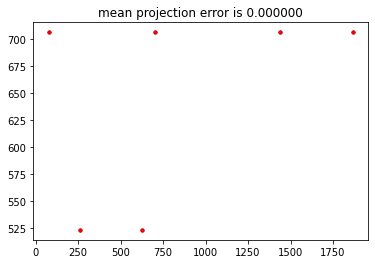

In [18]:
xyz = [[-875, 0, 9.755], [442, 0, 9.755], [1921, 0, 9.755], [2951, 0.5, 9.755], [-4132, 0.5, 23.618],
[-876, 0, 23.618]]
# Known pixel coordinates
uv = [[76, 706], [702, 706], [1440, 706], [1867, 706], [264, 523], [625, 523]]

X = np.array(xyz).T
x = np.array(uv).T

P_DLT, P_N = computeP_DLT(x,X)
print(P_DLT)
displayResults(P_DLT, x, X, 'P_DLT')

[[  76  702 1440 1867  264  625]
 [ 706  706  706  706  523  523]]
iter 1 mean reprojection error 0.000000
iter 1 cost 0.000000
P_LM =
[[ 2.69200328e-04 -2.39666716e-01  1.21265421e-01 -9.03245197e-01]
 [-6.95593158e-06 -4.52970264e-02  7.45394075e-02 -3.23100152e-01]
 [-9.85259430e-09 -6.41600941e-05  1.57185128e-04 -9.61057968e-04]]
||P_LM||=1.000000


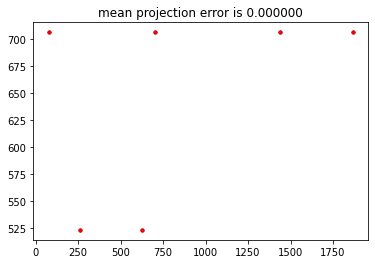

In [14]:
# use P_DLT as an initalization for LM
P_LM = P_N.copy()

# LM hyperparameters
l=0.001
eta = 10**-6 # for stopping
v=10
max_iters=10
# Data Normalization
xn, T = normalize(toHomo(x))
print(x)
xin = fromHomo(xn)
Xn, U = normalize(toHomo(X))

# Initial cost
x_measured = xin.T.flatten().reshape(-1,1)
x_estimated = proj(P_LM,fromHomo(Xn)).T.flatten().reshape(-1,1)
p = parameterize(P_LM)
scale = T[0,0]**2
cov = scale*np.eye(x_measured.shape[0])
cov_inv = np.linalg.inv(cov)
err = error(x_measured,x_estimated)
cost = calcCost(err,cov_inv)
P_LM = -1*P_LM

costs = []
costs.append(cost)

prev_cost = cost+1

# LM optimization loop
it = 0
while prev_cost-cost>eta:
    prev_cost = cost
    P_LM, l, err, cost = LMstep(P_LM, xin, Xn, l, v)
    P_LMDN = (np.linalg.pinv(T).dot(P_LM)).dot(U)
    P_LMDN = P_LMDN/np.sqrt(np.sum(P_LMDN**2))
    costs.append(cost)
    print ('iter %d mean reprojection error %f'%(it+1, rmse(x,proj(P_LMDN,X))))
    print ('iter %d cost %f'%(it+1, cost))
    it+=1
    
displayResults(P_LMDN, x, X, 'P_LM')
    